---
# Using the `LazyPlot`-package

This notebook shows a couple of functionalities of the `LazyPlot`-package, including reading in data, plotting + statistics, and deconvolution procedures.

In [1]:
from lazyplot import (
    plotting,
    glm,
    utils,
    fitting,
    dataset,
    preproc
)
import pingouin as pg
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

opj = os.path.join
opd = os.path.dirname

The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.


## Read data

In [3]:
data_dir = opj(opd(opd(plotting.__file__)), "data")
os.listdir(data_dir)

['betas.csv',
 'lazyprep',
 'glms.csv',
 'profiles.csv',
 'sub-01_ses-1_task-SRF_bold.mat',
 'sub-01_ses-1_desc-eye.h5',
 'sub-01_ses-1_task-SRF_eye.edf',
 'sub-01_ses-1_task-SRF_events.tsv']

In [4]:
func = opj(data_dir, "sub-01_ses-1_task-SRF_bold.mat")
tsv = opj(data_dir, "sub-01_ses-1_task-SRF_events.tsv")
edf = opj(data_dir, "sub-01_ses-1_task-SRF_eye.edf")
t = dataset.Dataset(
    func,
    tsv_file=tsv,
    # edf_file=edf,
    verbose=True,
    phase_onset=0,
    ica=True,
    report=True,
    merge=False,
    save_as="/data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/data/lazyprep"
)


DATASET

FUNCTIONAL
Preprocessing /data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/data/sub-01_ses-1_task-SRF_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'


 Baseline is 20 seconds, or 190 TRs
 Cutting 0 volumes from beginning (also cut from baseline (was 190, now 190 TRs) | 0 volumes from end
 DCT-high pass filter [removes low frequencies <0.01 Hz] to correct low-frequency drifts.
 Running FastICA with 5 components
 DCT high-pass filter on components [removes low frequencies <0.2 Hz]
 Writing /data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/data/lazyprep/sub-01/figures/sub-01_ses-1_task-SRF_run-1_desc-melodic.svg
 Regressing out all high-passed components [>0.2 Hz]
 Writing /data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/data/lazyprep/sub-01/figures/sub-01_ses-1_task-SRF_run-1_desc-ica.svg
 tSNR [before 'ica']: 6.56	| variance: 26.82
 tSNR [after 'ica']:  6.72	| variance: 25.85

EXPTOOLS
Preprocessing /data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/data/sub-01_ses-1_task-SRF_events.tsv
 1st 't' @37.13s
 Extracting ['b'] button(s)
 Cutting 37.13s from onsets
Saving report to /data1/projects/MicroFunc/Jurj

In [5]:
# preprocessed functional data (high-pass + ICA [5 comps])
t.fetch_fmri().head()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
01      1   0.000  24.120857  26.884216  -6.523689 -13.212784 -26.410568   
            0.105  60.904350  -4.066528  -5.549271  10.578316 -31.444496   
            0.210 -10.842934 -29.055473  15.535728 -36.002476  15.479637   
            0.315 -22.451332  -3.198692   1.316269 -10.250771 -12.907478   
            0.420  -4.934624   1.994682  50.188416  29.976738   4.476059   

                       vox 5      vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                             ...   
01      1   0.000   5.315002  38.903427  -3.039337  32.552017  -0.393814  ...   
            0.105 -13.776833   9.944603 -11.358406  31.305786   7.784966  ...   
            0.210  -7.587730  -1.707832  12.058670 -16.157288  -7.403816  ...   
            0.315 -26.392128   7.321152  50.494423   0.507004  22.063927  ...   
            0.420   9.072258  -2.892548  23.413292 -50.936039  16.053635  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
01      1   0.000  35.238235  68.940826 -46.369877 -12.008301   2.939949   
            0.105  29.101318  -1.237236  42.155548   2.658241  33.851761   
            0.210 -18.747208 -31.623657  -4.397964  79.508339  29.455521   
            0.315 -14.635674  -3.495094   5.431610 -13.444534 -14.753075   
            0.420  19.833008   1.415855   4.240723  38.267998  15.010330   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
01      1   0.000  41.984924  14.404655  10.435234  17.629417 -18.974983  
            0.105 -17.355698  15.824364  20.952316  28.794113  20.434326  
            0.210 -18.974464  -1.437401  45.921753 -24.293396   8.289497  
            0.315  -8.381752 -13.838013  27.244209  -5.284363 -31.195503  
            0.420  12.893570  -4.238480  62.481766 -34.293495  -0.052628  

[5 rows x 720 columns]

In [39]:
# event onsets
t.df_onsets.head()

onset
subject run event_type       
01      1   blink       2.266
            blink       2.607
            blink       2.707
            blink       2.767
            blink       2.853

In [36]:
# preprocessed eyetracking data (in eyetracking sampling time)
t.df_space_eye.head()

pupil  pupil_psc    pupil_int  pupil_int_psc  \
subject run eye t                                                     
01      1   L   0.000    0.0 -93.557716  2443.472412     136.718536   
                0.001    0.0 -93.557716  2443.438477     136.715347   
                0.002    0.0 -93.557716  2443.404541     136.712158   
                0.003    0.0 -93.557716  2443.370361     136.708939   
                0.004    0.0 -93.557716  2443.336426     136.705750   

                       gaze_x_int  gaze_x_int_psc  gaze_y_int  gaze_y_int_psc  \
subject run eye t                                                               
01      1   L   0.000  928.404724       -4.863655  528.082703        4.361069   
                0.001  928.402100       -4.863930  528.089233        4.362335   
                0.002  928.399536       -4.864197  528.095764        4.363594   
                0.003  928.396912       -4.864471  528.102356        4.364868   
                0.004  928.394287       -4.864746  528.108887        4.366127   

                       gaze_x  gaze_x_psc  gaze_y  gaze_y_psc  
subject run eye t                                              
01      1   L   0.000  0.0001 -103.795868  0.0001  -97.624184  
                0.001  0.0001 -103.795868  0.0001  -97.624184  
                0.002  0.0001 -103.795868  0.0001  -97.624184  
                0.003  0.0001 -103.795868  0.0001  -97.624184  
                0.004  0.0001 -103.795868  0.0001  -97.624184

## Statistics + plotting

In [75]:
glms = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","glms.csv"), usecols=lambda column: not column.startswith("Unnamed"))
profs = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","profiles.csv"), usecols=lambda column: not column.startswith("Unnamed")).set_index(["event_type","preproc","method","subject"])
betas = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","betas.csv"), usecols=lambda column: not column.startswith("Unnamed")).set_index(["event_type","method","preproc","model","model_ix"])

glms.head()

,beta,tstat,r2,subject,model,model_ix,method,preproc,event_type
0,0.981313,2.956407,0.326860,8,linear,0,raw,uncorr,center
1,-0.398325,-1.404422,0.396841,8,camel,1,raw,uncorr,center
2,-1.791440,-2.029122,0.606952,8,camel_deriv,2,raw,uncorr,center
3,0.678075,3.011143,0.334983,10,linear,0,raw,uncorr,center
4,0.469938,2.792047,0.544059,10,camel,1,raw,uncorr,center


In [20]:
# initialize regressors
n_steps = profs.shape[-1]
xx = np.arange(0,n_steps)
y1 = xx.copy()[::-1]
y1 = y1/y1.max()

y2 = np.linspace(-n_steps//2,n_steps//2,num=n_steps)
y2 = (y2**2)
y2 = y2/y2.max()

y = np.linspace(-10,10,num=20)
# print(y2.shape)
# y2 = (y2**2)
fc = 5
y_1 = stats.norm.pdf(y,-fc)
y_1 = y_1/y_1.max()
y_1d = np.gradient(y_1)

y_2 = stats.norm.pdf(y,fc)
y_2 = y_2/y_2.max()
y_2d = np.gradient(y_2)

y3 = y_1+y_2

reg_dict = {
    "linear": y1[...,np.newaxis],
    "camel": np.concatenate(
        [
            y1[...,np.newaxis],     # linear term
            y3[...,np.newaxis],    # fixed bumps
        ],
        axis=1
    )
}

# combine linear & camel
reg_dict["camel_deriv"] = np.concatenate(
    [
        y1[...,np.newaxis],     # linear term
        y_1[...,np.newaxis],    # first bump
        y_2[...,np.newaxis],    # second bump
        y_1d[...,np.newaxis],   # first bump deriv
        y_2d[...,np.newaxis]    # second bump deriv
    ],
    axis=1
)

## Create bar plot + significance bars based on ANOVAs


              W      pval  normal
beta  0.948999  0.124379    True

        Source  ddof1  ddof2         F     p-unc       np2
0  event_type      2     30  7.107614  0.002973  0.321501


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,distances
0,event_type,center,large\nannulus,True,True,-4.005559,10.0,two-sided,0.002496,0.007488,holm,18.86,-1.369197,2
1,event_type,center,medium\nannulus,True,True,-3.146138,10.0,two-sided,0.010401,0.020802,holm,5.864,-1.505014,1
2,event_type,large\nannulus,medium\nannulus,True,True,1.330295,10.0,two-sided,0.212961,0.212961,holm,0.603,0.571084,1


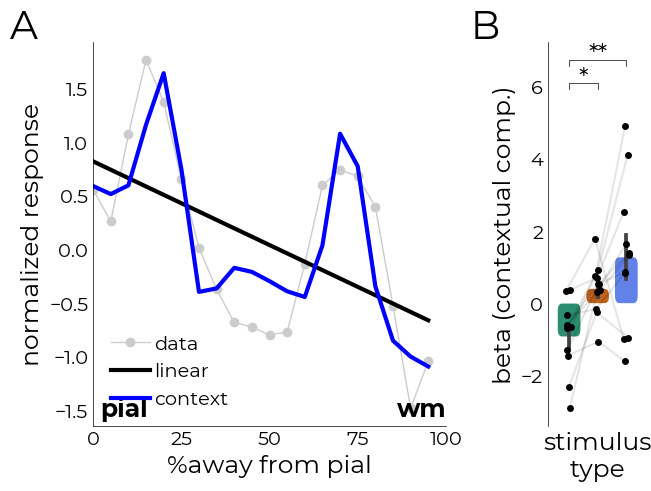

In [ ]:
%matplotlib inline
n_elem = betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    betas,
    expression=expr
)

data = utils.multiselect_from_df(profs, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "context"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = plotting.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyLine(
    data_list,
    **def_dict
)

plotting.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    connect=True
)


normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)

print("\n", normality)
print("\n", aov.ano)
aov.posthoc

## Fitting procedures

You can either input your entire dataset in the fitter, or select a subset of the dataframe using `utils.select_from_df()` based on the columns (used `indices=[354,360]`) or rows/index (`expression="index = value"`):

In [48]:
# select particular run
func = utils.select_from_df(
    t.fetch_fmri(),
    expression="run = 1"
)
func.head()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
01      1   0.000  24.120857  26.884216  -6.523689 -13.212784 -26.410568   
            0.105  60.904350  -4.066574  -5.549278  10.578316 -31.444489   
            0.210 -10.842934 -29.055458  15.535736 -36.002476  15.479637   
            0.315 -22.451332  -3.198692   1.316269 -10.250771 -12.907478   
            0.420  -4.934631   1.994690  50.188416  29.976738   4.476059   

                       vox 5      vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                             ...   
01      1   0.000   5.315010  38.903427  -3.039322  32.552017  -0.393814  ...   
            0.105 -13.776825   9.944611 -11.358414  31.305786   7.784966  ...   
            0.210  -7.587723  -1.707832  12.058678 -16.157280  -7.403816  ...   
            0.315 -26.392120   7.321152  50.494423   0.507004  22.063934  ...   
            0.420   9.072266  -2.892555  23.413292 -50.936035  16.053627  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
01      1   0.000  35.238235  68.940826 -46.369884 -12.008301   2.939949   
            0.105  29.101318  -1.237221  42.155563   2.658241  33.851746   
            0.210 -18.747215 -31.623657  -4.397972  79.508339  29.455521   
            0.315 -14.635674  -3.495102   5.431618 -13.444534 -14.753075   
            0.420  19.833008   1.415855   4.240723  38.267998  15.010330   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
01      1   0.000  41.984924  14.404648  10.435234  17.629425 -18.974983  
            0.105 -17.355682  15.824364  20.952316  28.794090  20.434334  
            0.210 -18.974464  -1.437401  45.921753 -24.293396   8.289497  
            0.315  -8.381752 -13.838005  27.244209  -5.284348 -31.195511  
            0.420  12.893570  -4.238480  62.481750 -34.293495  -0.052635  

[5 rows x 720 columns]

In [51]:
t.fetch_fmri()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
01      1   0.000    24.120857  26.884216  -6.523689 -13.212784 -26.410568   
            0.105    60.904350  -4.066574  -5.549278  10.578316 -31.444489   
            0.210   -10.842934 -29.055458  15.535736 -36.002476  15.479637   
            0.315   -22.451332  -3.198692   1.316269 -10.250771 -12.907478   
            0.420    -4.934631   1.994690  50.188416  29.976738   4.476059   
...                        ...        ...        ...        ...        ...   
            377.475 -12.011856 -27.804138  -4.247749   3.850456  13.434723   
            377.580   0.978790  12.072556   1.603676  16.085052  -8.246353   
            377.685 -35.623585   9.984314  51.675293   1.970299  40.135185   
            377.790  37.096840 -13.449600  17.217293 -12.686501  11.852112   
            377.895 -14.316574  14.075378  20.446724  -9.932907  25.556320   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
01      1   0.000     5.315010  38.903427  -3.039322  32.552017  -0.393814   
            0.105   -13.776825   9.944611 -11.358414  31.305786   7.784966   
            0.210    -7.587723  -1.707832  12.058678 -16.157280  -7.403816   
            0.315   -26.392120   7.321152  50.494423   0.507004  22.063934   
            0.420     9.072266  -2.892555  23.413292 -50.936035  16.053627   
...                        ...        ...        ...        ...        ...   
            377.475 -13.325867 -11.991295  48.694618 -14.418304  17.417755   
            377.580  -9.025581 -13.307068  13.437386  21.946434  -9.838951   
            377.685 -20.763458   8.739799 -10.021507  34.045151   0.650848   
            377.790  16.513237   3.448250  21.950851  23.538940  -1.577179   
            377.895   5.452850  20.317665  32.211700   5.674561   7.165550   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
01      1   0.000    ...  35.238235  68.940826 -46.369884 -12.008301   
            0.105    ...  29.101318  -1.237221  42.155563   2.658241   
            0.210    ... -18.747215 -31.623657  -4.397972  79.508339   
            0.315    ... -14.635674  -3.495102   5.431618 -13.444534   
            0.420    ...  19.833008   1.415855   4.240723  38.267998   
...                  ...        ...        ...        ...        ...   
            377.475  ...  11.003349   5.086441   9.591003   2.009308   
            377.580  ... -13.095093 -42.527153  32.515060 -12.019279   
            377.685  ... -23.774284 -25.980843 -27.767578 -10.051491   
            377.790  ... -10.944664  12.543343  -3.919060   3.668907   
            377.895  ...   2.156197  24.890884 -15.975479  27.382568   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
01      1   0.000     2.939949  41.984924  14.404648  10.435234  17.629425   
            0.105    33.851746 -17.355682  15.824364  20.952316  28.794090   
            0.210    29.455521 -18.974464  -1.437401  45.921753 -24.293396   
            0.315   -14.753075  -8.381752 -13.838005  27.244209  -5.284348   
            0.420    15.010330  12.893570  -4.238480  62.481750 -34.293495   
...                        ...        ...        ...        ...        ...   
            377.475  -1.192665 -31.425140  19.871780   9.320892 -31.429909   
            377.580  20.574982  23.910011 -13.735176 -39.035683 -10.055664   
            377.685  39.635071  14.152115  16.660057  34.088943  18.116882   
            377.790   4.819633   9.076469  15.658318 -12.368950 -27.114120   
            377.895 -13.209061  -3.198753 -20.116135 -11.395523  21.582146   

                       vox 719  
subject ru

In [6]:
# select columns
func = utils.select_from_df(
    t.fetch_fmri(),
    indices=(358,363)
)
func.head()

Fetching dataframe from attribute 'df_func_ica'


vox 358   vox 359   vox 360   vox 361   vox 362
subject run t                                                       
01      1   0.000 -13.839180 -0.588196 -8.102226 -2.139961  4.546150
            0.105 -15.945488 -1.409012  9.016472 -4.400391 -0.167267
            0.210   3.386169 -2.018173 -1.606468  3.617477 -4.278786
            0.315   4.105835 -4.456383 -5.251755  7.006042  1.271141
            0.420  16.345665 -4.209221 -5.079636  0.242386 -9.488396

### Deconvolution

In [7]:
# initialize the fitter
dec = fitting.NideconvFitter(
    func,
    t.fetch_onsets(),
    basis_sets="canonical_hrf_with_time_derivative",
    TR=0.105,
    interval=[-2,16],
    verbose=True,
    conf_intercept=False
)

dec.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x7f89e839a730>


In [8]:
# average over the voxels and parse into list
evs = utils.get_unique_ids(dec.tc_condition, id="event_type")

tc,se,pr = [],[],[]
for i in evs:
    avg = utils.select_from_df(
        dec.tc_condition,
        expression=f"event_type = {i}"
    )

    pred = utils.select_from_df(
        dec.ev_predictions,
        expression=f"event_type = {i}"
    )

    tc.append(avg.mean(axis=1).values)
    se.append(avg.sem(axis=1).values)
    pr.append(pred.mean(axis=1).values)

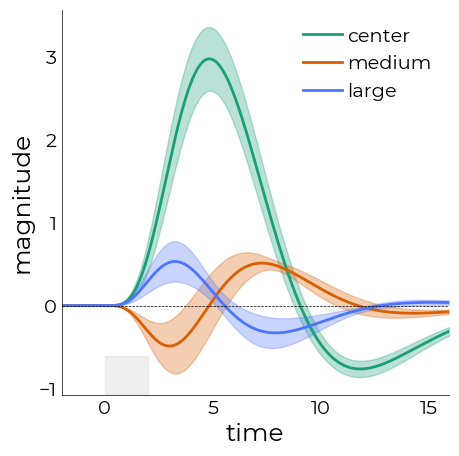

In [67]:
%matplotlib inline

# do some plotting
pl = plotting.LazyLine(
    tc,
    xx=dec.time,
    figsize=(5,5),
    color=["#1B9E77","#D95F02","#4c75ff"],
    error=se,
    line_width=2,
    labels=["center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0
)

plotting.add_axvspan(
    pl.axs, 
    ymax=0.1
)

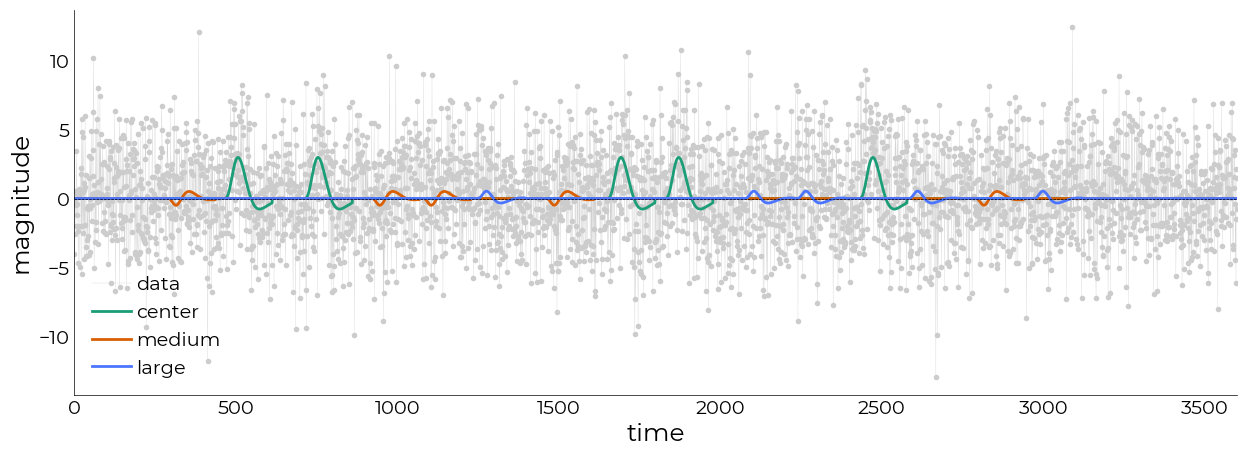

In [68]:
%matplotlib inline

# do some plotting
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    figsize=(15,5),
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None]
)

## Do some filtering

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x7f89d34ad5b0>


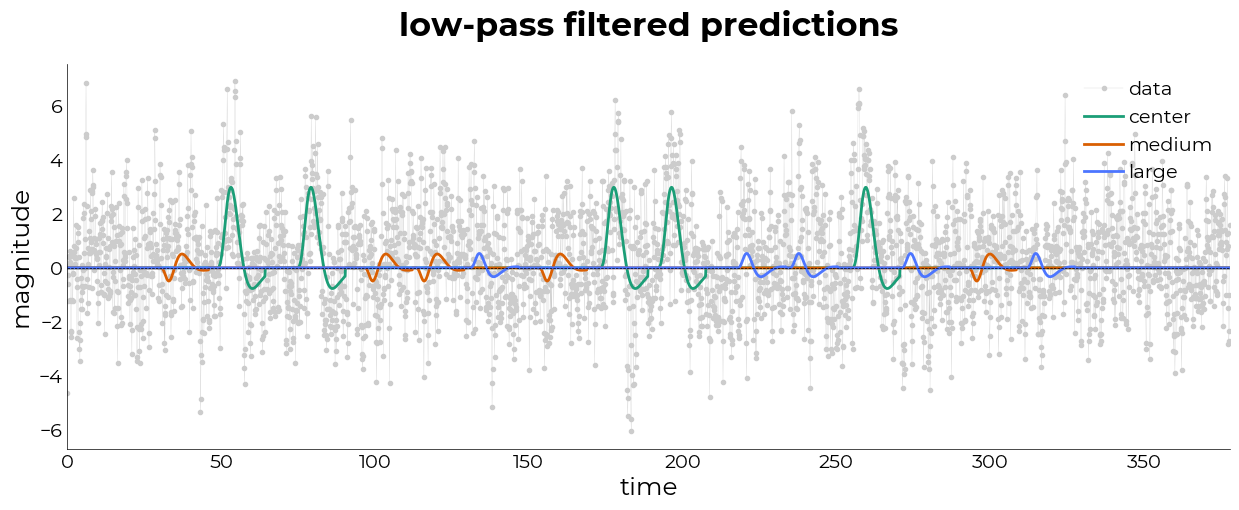

In [69]:
%matplotlib inline

filt = preproc.DataFilter(
    dec.func,
    filter_strategy="lp"
)

# initialize the fitter
dec = fitting.NideconvFitter(
    filt.df_filt,
    t.fetch_onsets(),
    basis_sets="canonical_hrf_with_time_derivative",
    TR=0.105,
    interval=[-2,16],
    verbose=True,
    conf_intercept=False
)

dec.timecourses_condition()

# average over the voxels and parse into list
evs = utils.get_unique_ids(dec.tc_condition, id="event_type")

tc,se,pr = [],[],[]
for i in evs:
    avg = utils.select_from_df(
        dec.tc_condition,
        expression=f"event_type = {i}"
    )

    pred = utils.select_from_df(
        dec.ev_predictions,
        expression=f"event_type = {i}"
    )

    tc.append(avg.mean(axis=1).values)
    se.append(avg.sem(axis=1).values)
    pr.append(pred.mean(axis=1).values)


# do some plotting
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    xx=utils.get_unique_ids(dec.func, id="t"),
    figsize=(15,5),
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None],
    title={
        "title": "low-pass filtered predictions",
        "fontweight": "bold"
    }
)


These classes also have the capability to extract relevant information from the deconvolved HRF profiles. The success of the estimation depends on the basis sets used and the quality of the data.

In [70]:
dec.parameters_for_tc_subjects()
dec.pars_subjects.head()

Deriving parameters from <lazyplot.fitting.NideconvFitter object at 0x7f89d3017a60> with 'HRFMetrics'


magnitude  magnitude_ix      fwhm  \
subject event_type run vox                                          
01      act        1   vox 358   2.467385          1485  4.364708   
                       vox 359   2.800161          1206  4.145990   
                       vox 360   2.781085          1197  4.108062   
                       vox 361   2.950958          1328  4.450755   
                       vox 362   4.426421          1316  4.438020   

                                                                        fwhm_obj  \
subject event_type run vox                                                         
01      act        1   vox 358  <lazyplot.fitting.FWHM object at 0x7f89d3391fa0>   
                       vox 359  <lazyplot.fitting.FWHM object at 0x7f89d3391f40>   
                       vox 360  <lazyplot.fitting.FWHM object at 0x7f89d3391e50>   
                       vox 361  <lazyplot.fitting.FWHM object at 0x7f89d339fca0>   
                       vox 362  <lazyplot.fitting.FWHM object at 0x7f89d339f6d0>   

                                time_to_peak  half_rise_time  half_max  \
subject event_type run vox                                               
01      act        1   vox 358      5.798530        3.805661  1.233693   
                       vox 359      4.333352        2.446802  1.400081   
                       vox 360      4.286088        2.419819  1.390543   
                       vox 361      4.974039        2.909467  1.475479   
                       vox 362      4.911021        2.855035  2.213210   

                                rise_slope  onset_time  positive_area  \
subject event_type run vox                                              
01      act        1   vox 358    1.005413    2.585284      10.658011   
                       vox 359    1.182192    1.263847      11.574175   
                       vox 360    1.186397    1.249140      11.390857   
                       vox 361    1.110626    1.579635      13.111733   
                       vox 362    1.677230    1.534548      19.605633   

                                undershoot  1st_deriv_magnitude  \
subject event_type run vox                                        
01      act        1   vox 358    2.815078            -0.115785   
                       vox 359    3.700138             1.241339   
                       vox 360    3.689476             1.246223   
                       vox 361    3.737903             1.166974   
                       vox 362    5.632656             1.762064   

                                1st_deriv_time_to_peak  2nd_deriv_magnitude  \
subject event_type run vox                                                    
01      act        1   vox 358                1.192934            -0.174174   
                       vox 359                2.421793             0.918948   
                       vox 360                2.395535             0.932818   
                       vox 361                2.920689             0.735574   
                       vox 362                2.857670             1.125010   

                                2nd_deriv_time_to_peak  
subject event_type run vox                              
01      act        1   vox 358                0.741302  
                       vox 359                1.313719  
                       vox 360                1.297964  
                       vox 361                1.670823  
                       vox 362                1.618308


                   W     pval  normal
magnitude  0.962036  0.72774    True

        Source  ddof1  ddof2          F     p-unc       np2
0  event_type      2     12  17.527378  0.000275  0.744978

      Contrast        A        B  Paired  Parametric         T  dof  \
1  event_type      act  suppr_2    True        True  5.034701  4.0   
0  event_type      act  suppr_1    True        True  6.164322  4.0   
2  event_type  suppr_1  suppr_2    True        True -0.784914  4.0   

  alternative     p-unc    p-corr p-adjust    BF10     cohen  distances  
1   two-sided  0.007309  0.014619     holm   8.842  3.558565          2  
0   two-sided  0.003516  0.010547     holm  15.037  3.199652          1  
2   two-sided  0.476385  0.476385     holm   0.505 -0.439769          1  


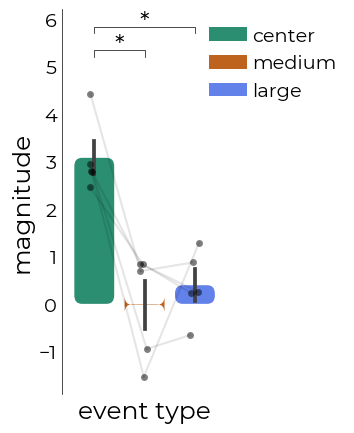

In [66]:
# which we can then flop into a LazyBar-object
br = plotting.LazyBar(
    dec.pars_subjects,
    figsize=(2,5),
    x="event_type",
    y="magnitude",
    sns_offset=4,
    fancy=True,
    x_label="event type",
    y_label="magnitude",
    connect=True,
    points_color="k",
    points_alpha=0.5,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    lbl_legend=["center","medium","large"],
    bar_legend=True,
    bbox_to_anchor=(0.8,1)
)

# add the stats
normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "vox",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

print("\n", normality)
print("\n", aov.ano)
print("\n", aov.posthoc_sorted)

# Plot histograms

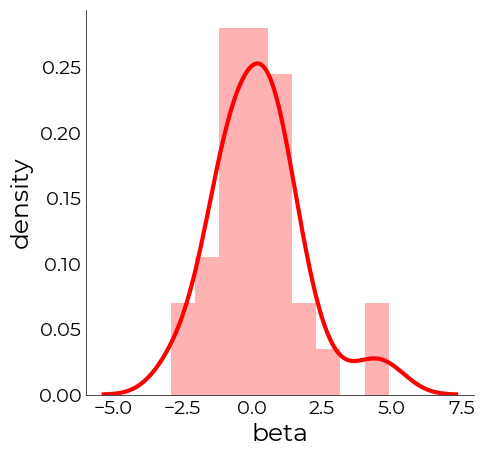

In [90]:
plotting.LazyHist(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    )["beta"],
    figsize=(5,5),
    kde=True,
    color="r",
    kde_kwargs={
        "linewidth": 3,
    },
    hist_kwargs={
        "alpha": 0.3,
        "fc": "r"
    },
    x_label="beta",
    y_label="density"
)

## Summary Figure

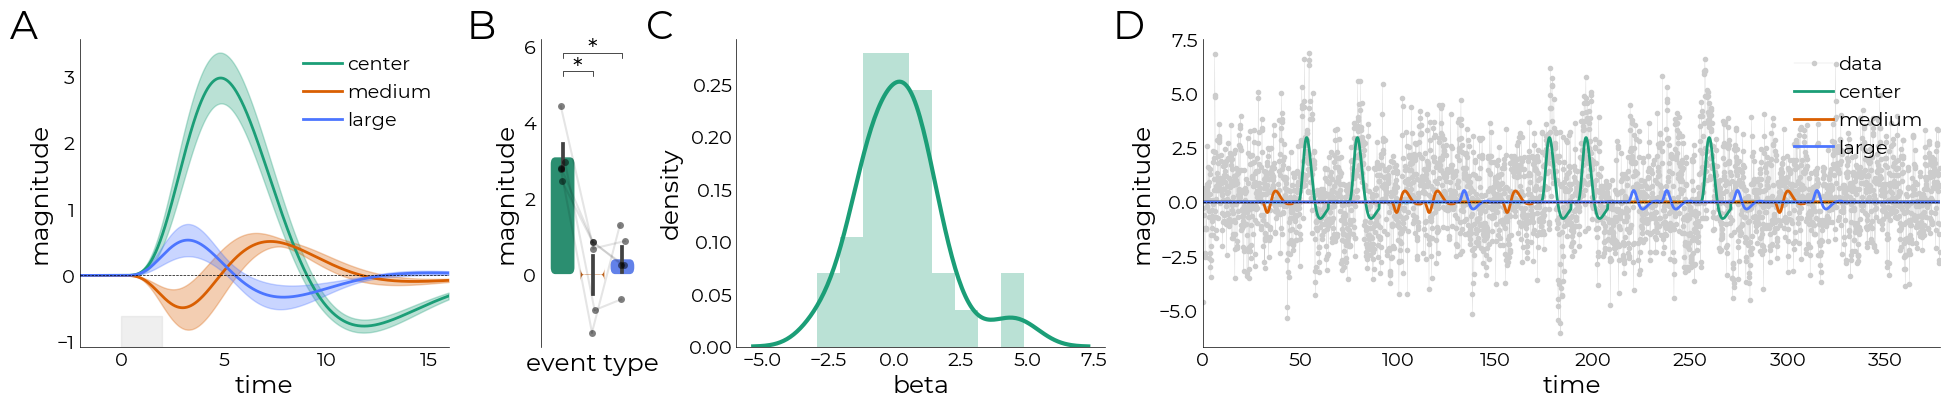

In [121]:
fig,axs = plt.subplots(
    ncols=4,
    width_ratios=[0.2,0.05,0.2,0.4],
    figsize=(24,4),
    gridspec_kw={
        "wspace": 0.25
    }
)

# LazyLine
pl = plotting.LazyLine(
    tc,
    xx=dec.time,
    axs=axs[0],
    color=["#1B9E77","#D95F02","#4c75ff"],
    error=se,
    line_width=2,
    labels=["center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0
)

plotting.add_axvspan(
    pl.axs, 
    ymax=0.1
)

# LazyBar
br = plotting.LazyBar(
    dec.pars_subjects,
    axs=axs[1],
    x="event_type",
    y="magnitude",
    sns_offset=4,
    fancy=True,
    x_label="event type",
    y_label="magnitude",
    connect=True,
    points_color="k",
    points_alpha=0.5,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    lbl_legend=["center","medium","large"],
)

# add the stats
normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "vox",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=-0.015,
    y_pos=1.15,
    line_separate_factor=-0.075
)

# LazyHist
plotting.LazyHist(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    )["beta"],
    axs=axs[2],
    kde=True,
    color="#1B9E77",
    kde_kwargs={
        "linewidth": 3,
    },
    hist_kwargs={
        "alpha": 0.3,
        "fc": "#1B9E77"
    },
    x_label="beta",
    y_label="density"
)

# Timecourse (predictions)
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    xx=utils.get_unique_ids(dec.func, id="t"),
    axs=axs[-1],
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None],
)

plotting.fig_annot(
    fig,
    x0_corr=-0.7,
    x_corr=[-0.8,-0.9,-0.9],
    y=1
)

fig.savefig(
    opj(data_dir, "example.png"),
    bbox_inches="tight",
    dpi=300,
    facecolor="white"
)